# Advanced Stance Visualization - Part 2

**Continuation of `stance_advanced_visualisation.ipynb`**

This notebook provides additional in-depth visualizations:
- Scatterplots (Divergence & Volume)
- Overlap/Agreement Analysis
- Correlation Matrices
- Stance Shift Diagrams (Slope Charts)
- Joint Distribution Heatmaps
- Radar Charts

**Prerequisites:** Run `stance_advanced_visualisation.ipynb` first to generate `advanced_stance_summary.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color schemes
STANCE_COLORS = {
    'favor': '#2ecc71',
    'against': '#e74c3c',
    'neutral': '#95a5a6'
}

PARTY_COLORS = {
    'pro ruling': '#FF6B35',
    'pro opposition': '#004E89'
}

BUCKET_COLORS = {
    'Economic': '#1abc9c',
    'Social/Religious': '#9b59b6',
    'Political/Policy': '#3498db',
    'Leadership': '#e67e22'
}

print("Libraries loaded!")

Libraries loaded!


## 1. Load Data

In [2]:
# Load the summary data from Part 1
if Path('advanced_stance_summary.csv').exists():
    polarization_df = pd.read_csv('advanced_stance_summary.csv')
    polarization_df.columns = ['keyword', 'bucket', 
                                'ruling_count', 'ruling_favor', 'ruling_against', 'ruling_neutral',
                                'opp_count', 'opp_favor', 'opp_against', 'opp_neutral',
                                'polarization_score', 'stance_divergence']
    print(f"✓ Loaded {len(polarization_df)} keywords from summary")
else:
    raise FileNotFoundError("Run stance_advanced_visualisation.ipynb first!")

# Load raw data for detailed analysis
CSV1 = "/scratch/ziv_baretto/Research_X/Partisan-Discourse-on-X-English-/codes/6_stance/results/stance_results_23keywords_v2.csv"
CSV2 = "/scratch/ziv_baretto/Research_X/Partisan-Discourse-on-X-English-/codes/6_stance/results/stance_results_run1_15_keywords.csv"

dfs = []
for csv_path in [CSV1, CSV2]:
    if Path(csv_path).exists():
        temp_df = pd.read_csv(csv_path)
        print(f"✓ Loaded {len(temp_df):,} rows from {Path(csv_path).name}")
        dfs.append(temp_df)

df = pd.concat(dfs, axis=0, ignore_index=True)
df = df.drop_duplicates(subset=['source_row', 'keyword'], keep='first')

# Filter and standardize
valid_stances = ['favor', 'against', 'neutral']
df = df[df['fewshot_label'].isin(valid_stances)].copy()
df['stance'] = df['fewshot_label']
df['party'] = df['_label_norm'].str.lower().str.strip()
df['keyword'] = df['keyword'].str.lower().str.strip()
df = df[df['party'].isin(['pro ruling', 'pro opposition'])]

# Add bucket classification
KEYWORD_BUCKETS = {
    'Economic': ['gdp', 'inflation', 'unemployment', 'msp', 'aatmanirbhar', 'economy', 'budget'],
    'Social/Religious': ['ayodhya', 'minorities', 'islamists', 'sangh', 'hathras', 'ucc', 
                         'hindu', 'hindus', 'muslim', 'muslims', 'ram'],
    'Political/Policy': ['caa', 'farm', 'democracy', 'mahotsav', 'bjp', 'congress', 
                         'election', 'protest', 'farmers'],
    'Leadership': ['modi', 'bhakts', 'rahul', 'gandhi', 'pm']
}

def get_bucket(keyword):
    keyword_lower = keyword.lower()
    for bucket, keywords in KEYWORD_BUCKETS.items():
        for kw in keywords:
            if kw in keyword_lower:
                return bucket
    return 'Other'

df['bucket'] = df['keyword'].apply(get_bucket)

print(f"\n✓ Final dataset: {len(df):,} tweets")

✓ Loaded 36 keywords from summary
✓ Loaded 59,357 rows from stance_results_23keywords_v2.csv


✓ Loaded 141,311 rows from stance_results_run1_15_keywords.csv

✓ Final dataset: 196,684 tweets


## 2. Scatterplot: Stance Divergence

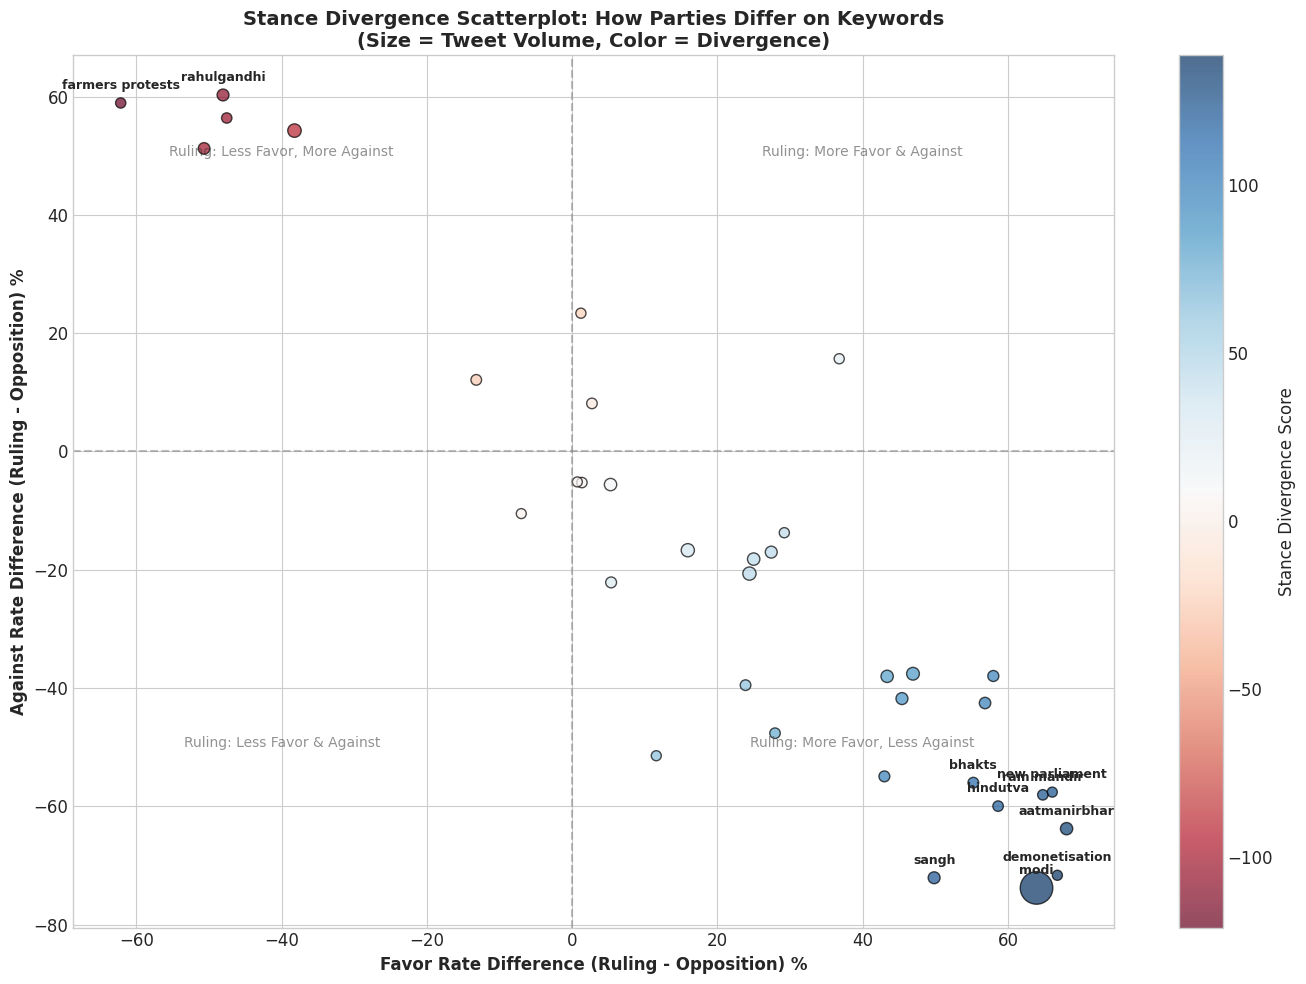

Saved: stance_scatterplot_divergence.png


In [4]:
# ============================================================================
# SCATTERPLOT: FAVOR vs AGAINST DIFFERENCE
# X = Favor rate difference, Y = Against rate difference
# Size = Total tweet volume, Color = Stance divergence score
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 10))

scatter_data = polarization_df.copy()
scatter_data['total'] = scatter_data['ruling_count'] + scatter_data['opp_count']
sizes = (scatter_data['total'] / scatter_data['total'].max()) * 500 + 50
colors = scatter_data['stance_divergence']

scatter_data['favor_diff'] = scatter_data['ruling_favor'] - scatter_data['opp_favor']
scatter_data['against_diff'] = scatter_data['ruling_against'] - scatter_data['opp_against']

scatter = ax.scatter(scatter_data['favor_diff'], scatter_data['against_diff'], 
                     s=sizes, c=colors, cmap='RdBu', alpha=0.7, edgecolors='black', linewidth=1)

# Label top 10 most polarizing keywords
for idx, row in scatter_data.head(10).iterrows():
    ax.annotate(row['keyword'], (row['favor_diff'], row['against_diff']),
                fontsize=9, fontweight='bold', ha='center', va='bottom',
                xytext=(0, 8), textcoords='offset points')

# Quadrant reference lines
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Quadrant labels
ax.text(40, 50, 'Ruling: More Favor & Against', fontsize=10, ha='center', alpha=0.5)
ax.text(-40, 50, 'Ruling: Less Favor, More Against', fontsize=10, ha='center', alpha=0.5)
ax.text(40, -50, 'Ruling: More Favor, Less Against', fontsize=10, ha='center', alpha=0.5)
ax.text(-40, -50, 'Ruling: Less Favor & Against', fontsize=10, ha='center', alpha=0.5)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Stance Divergence Score', fontsize=12)

ax.set_xlabel('Favor Rate Difference (Ruling - Opposition) %', fontweight='bold', fontsize=12)
ax.set_ylabel('Against Rate Difference (Ruling - Opposition) %', fontweight='bold', fontsize=12)
ax.set_title('Stance Divergence Scatterplot: How Parties Differ on Keywords\n(Size = Tweet Volume, Color = Divergence)', 
            fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('stance_scatterplot_divergence.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_scatterplot_divergence.png")

## 3. Scatterplot: Keyword Volume by Party

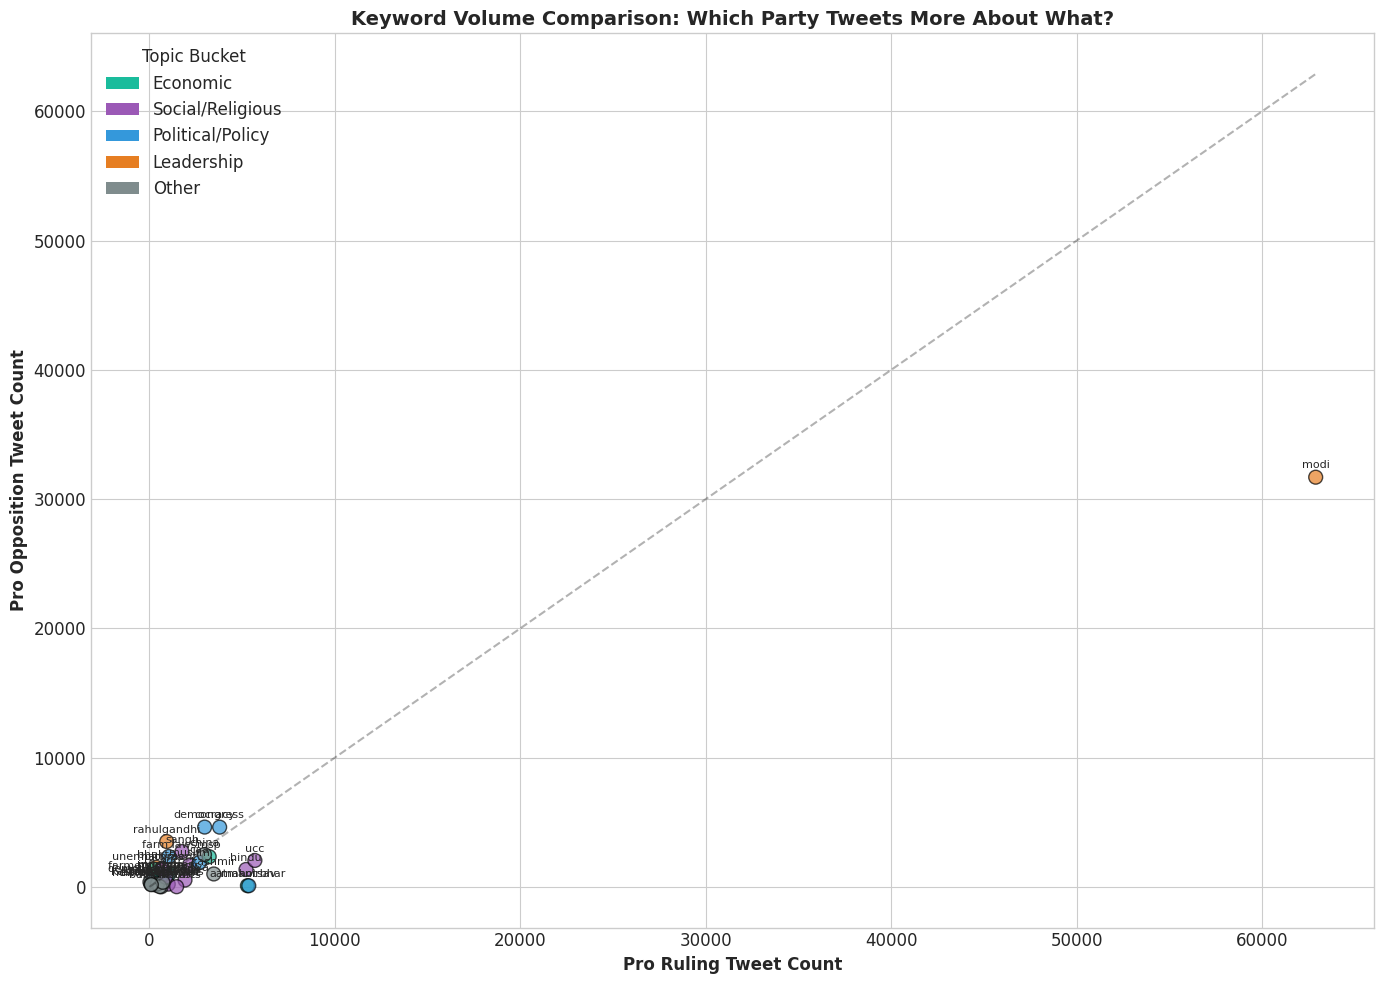

Saved: keyword_volume_scatter.png


In [4]:
# ============================================================================
# SCATTERPLOT: TWEET VOLUME BY PARTY
# X = Pro Ruling count, Y = Pro Opposition count
# Color = Topic bucket
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 10))

scatter_vol = polarization_df.copy()
colors_vol = [BUCKET_COLORS.get(b, '#7f8c8d') for b in scatter_vol['bucket']]

ax.scatter(scatter_vol['ruling_count'], scatter_vol['opp_count'], 
           s=100, c=colors_vol, alpha=0.7, edgecolors='black', linewidth=1)

# Label all keywords
for idx, row in scatter_vol.iterrows():
    ax.annotate(row['keyword'], (row['ruling_count'], row['opp_count']),
                fontsize=8, ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

# Equal representation diagonal
max_count = max(scatter_vol['ruling_count'].max(), scatter_vol['opp_count'].max())
ax.plot([0, max_count], [0, max_count], 'k--', alpha=0.3, label='Equal representation')

# Legend for buckets
legend_elements = [Patch(facecolor=color, label=bucket) for bucket, color in BUCKET_COLORS.items()]
legend_elements.append(Patch(facecolor='#7f8c8d', label='Other'))
ax.legend(handles=legend_elements, loc='upper left', title='Topic Bucket')

ax.set_xlabel('Pro Ruling Tweet Count', fontweight='bold', fontsize=12)
ax.set_ylabel('Pro Opposition Tweet Count', fontweight='bold', fontsize=12)
ax.set_title('Keyword Volume Comparison: Which Party Tweets More About What?', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('keyword_volume_scatter.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: keyword_volume_scatter.png")

## 4. Overlap Analysis: Party Agreement/Disagreement

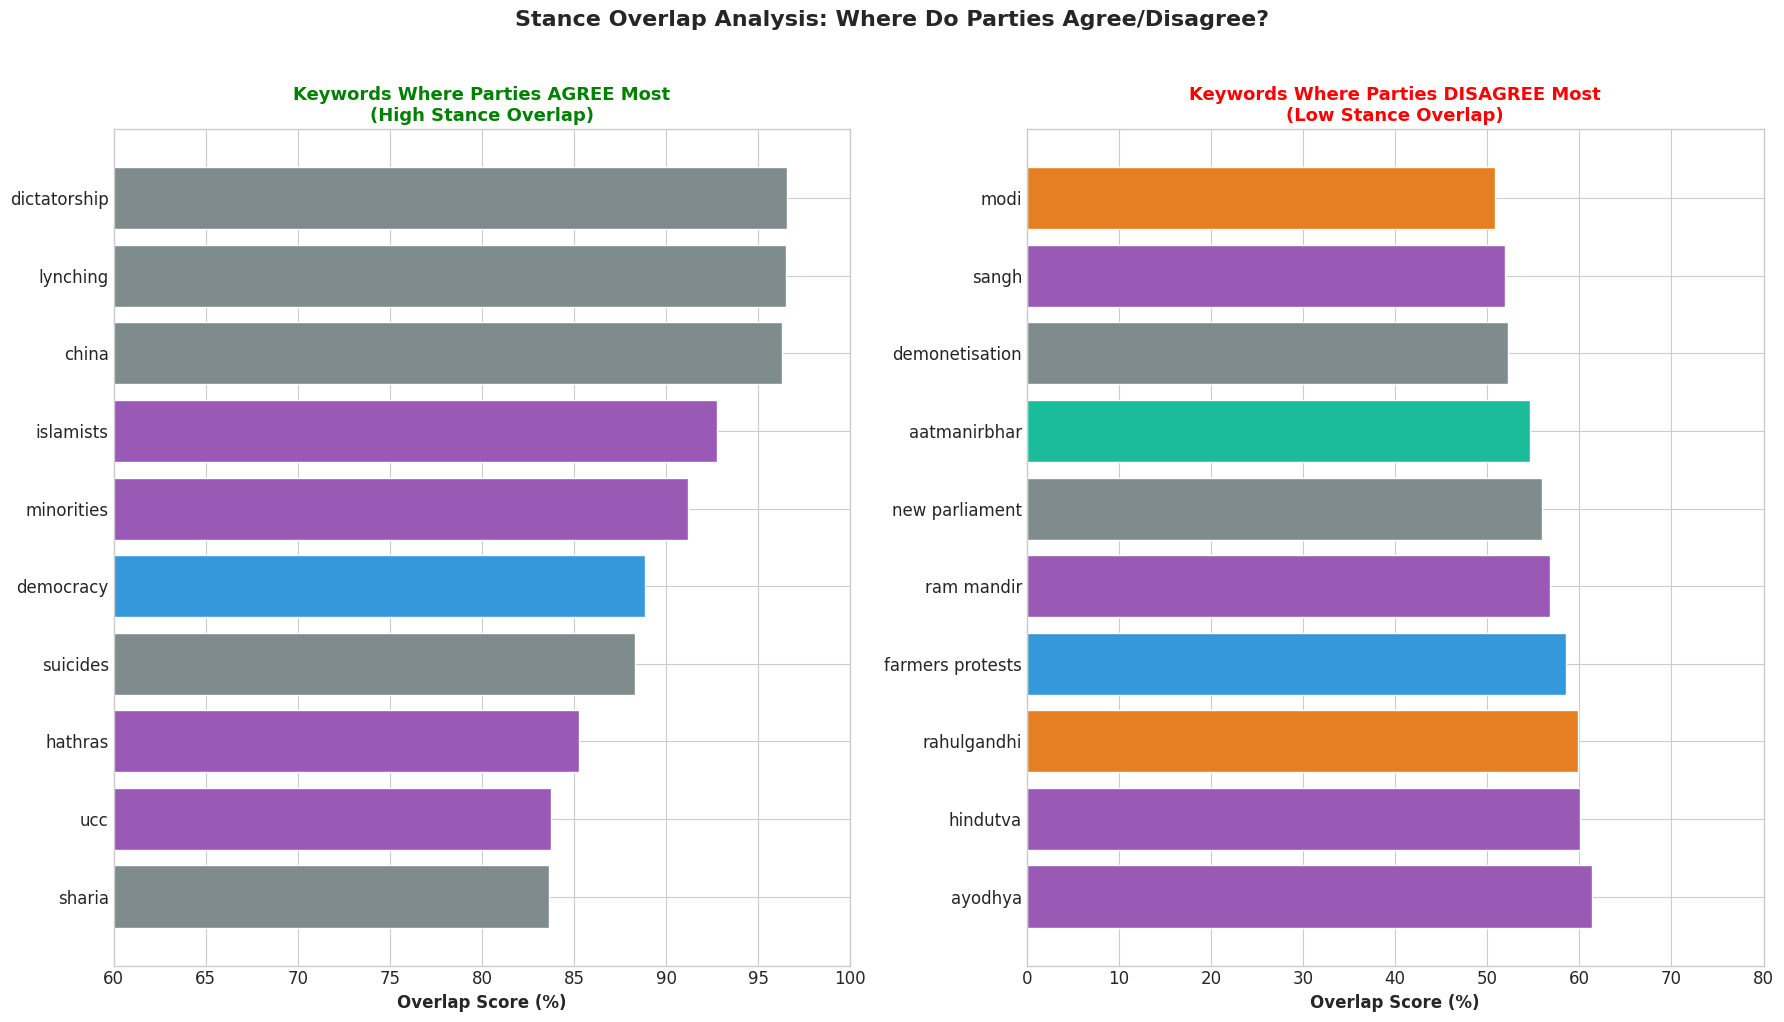

Saved: stance_overlap_analysis.png


In [5]:
# ============================================================================
# OVERLAP ANALYSIS: WHERE DO PARTIES AGREE/DISAGREE?
# Higher overlap score = more similar stance distributions
# ============================================================================

def calculate_overlap_score(row):
    """Calculate overlap score between parties for a keyword."""
    favor_overlap = 100 - abs(row['ruling_favor'] - row['opp_favor'])
    against_overlap = 100 - abs(row['ruling_against'] - row['opp_against'])
    neutral_overlap = 100 - abs(row['ruling_neutral'] - row['opp_neutral'])
    return (favor_overlap + against_overlap + neutral_overlap) / 3

overlap_df = polarization_df.copy()
overlap_df['overlap_score'] = overlap_df.apply(calculate_overlap_score, axis=1)
overlap_df = overlap_df.sort_values('overlap_score', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Left: HIGH overlap (parties agree)
high_overlap = overlap_df.head(10)
colors_high = [BUCKET_COLORS.get(b, '#7f8c8d') for b in high_overlap['bucket']]
axes[0].barh(high_overlap['keyword'], high_overlap['overlap_score'], 
             color=colors_high, edgecolor='white')
axes[0].set_xlabel('Overlap Score (%)', fontweight='bold')
axes[0].set_title('Keywords Where Parties AGREE Most\n(High Stance Overlap)', 
                  fontweight='bold', fontsize=13, color='green')
axes[0].invert_yaxis()
axes[0].set_xlim(60, 100)

# Right: LOW overlap (parties disagree)
low_overlap = overlap_df.tail(10).sort_values('overlap_score', ascending=True)
colors_low = [BUCKET_COLORS.get(b, '#7f8c8d') for b in low_overlap['bucket']]
axes[1].barh(low_overlap['keyword'], low_overlap['overlap_score'], 
             color=colors_low, edgecolor='white')
axes[1].set_xlabel('Overlap Score (%)', fontweight='bold')
axes[1].set_title('Keywords Where Parties DISAGREE Most\n(Low Stance Overlap)', 
                  fontweight='bold', fontsize=13, color='red')
axes[1].invert_yaxis()
axes[1].set_xlim(0, 80)

plt.suptitle('Stance Overlap Analysis: Where Do Parties Agree/Disagree?', 
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('stance_overlap_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_overlap_analysis.png")

## 5. Correlation Matrix

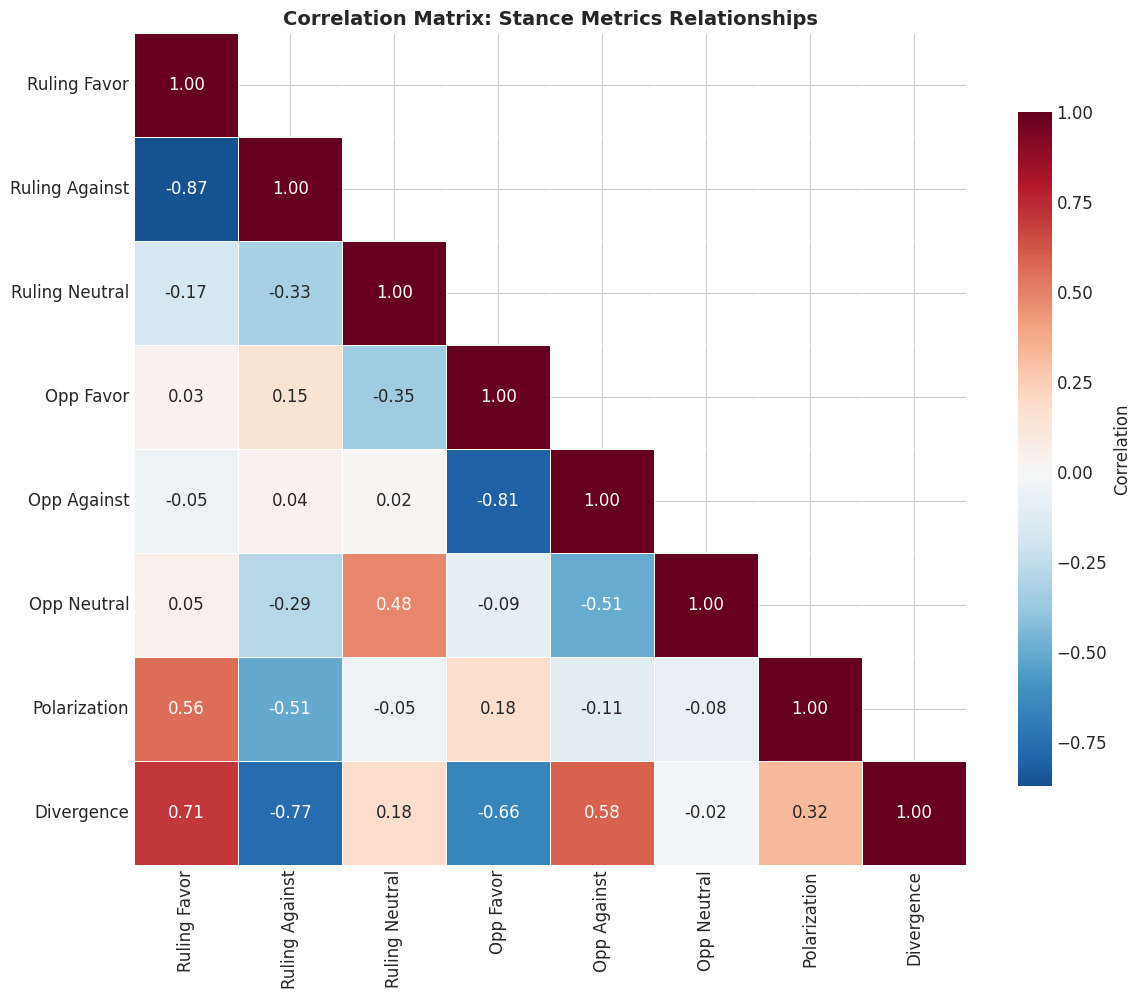

Saved: stance_correlation_matrix.png


In [6]:
# ============================================================================
# CORRELATION HEATMAP: RELATIONSHIPS BETWEEN METRICS
# ============================================================================

corr_cols = ['ruling_favor', 'ruling_against', 'ruling_neutral',
             'opp_favor', 'opp_against', 'opp_neutral',
             'polarization_score', 'stance_divergence']

corr_matrix = polarization_df[corr_cols].corr()

# Rename for readability
corr_matrix.columns = ['Ruling Favor', 'Ruling Against', 'Ruling Neutral',
                       'Opp Favor', 'Opp Against', 'Opp Neutral',
                       'Polarization', 'Divergence']
corr_matrix.index = corr_matrix.columns

fig, ax = plt.subplots(figsize=(12, 10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=ax, mask=mask, linewidths=0.5,
            cbar_kws={'label': 'Correlation', 'shrink': 0.8})

ax.set_title('Correlation Matrix: Stance Metrics Relationships', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('stance_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_correlation_matrix.png")

## 6. Stance Shift Diagrams (Slope Charts)

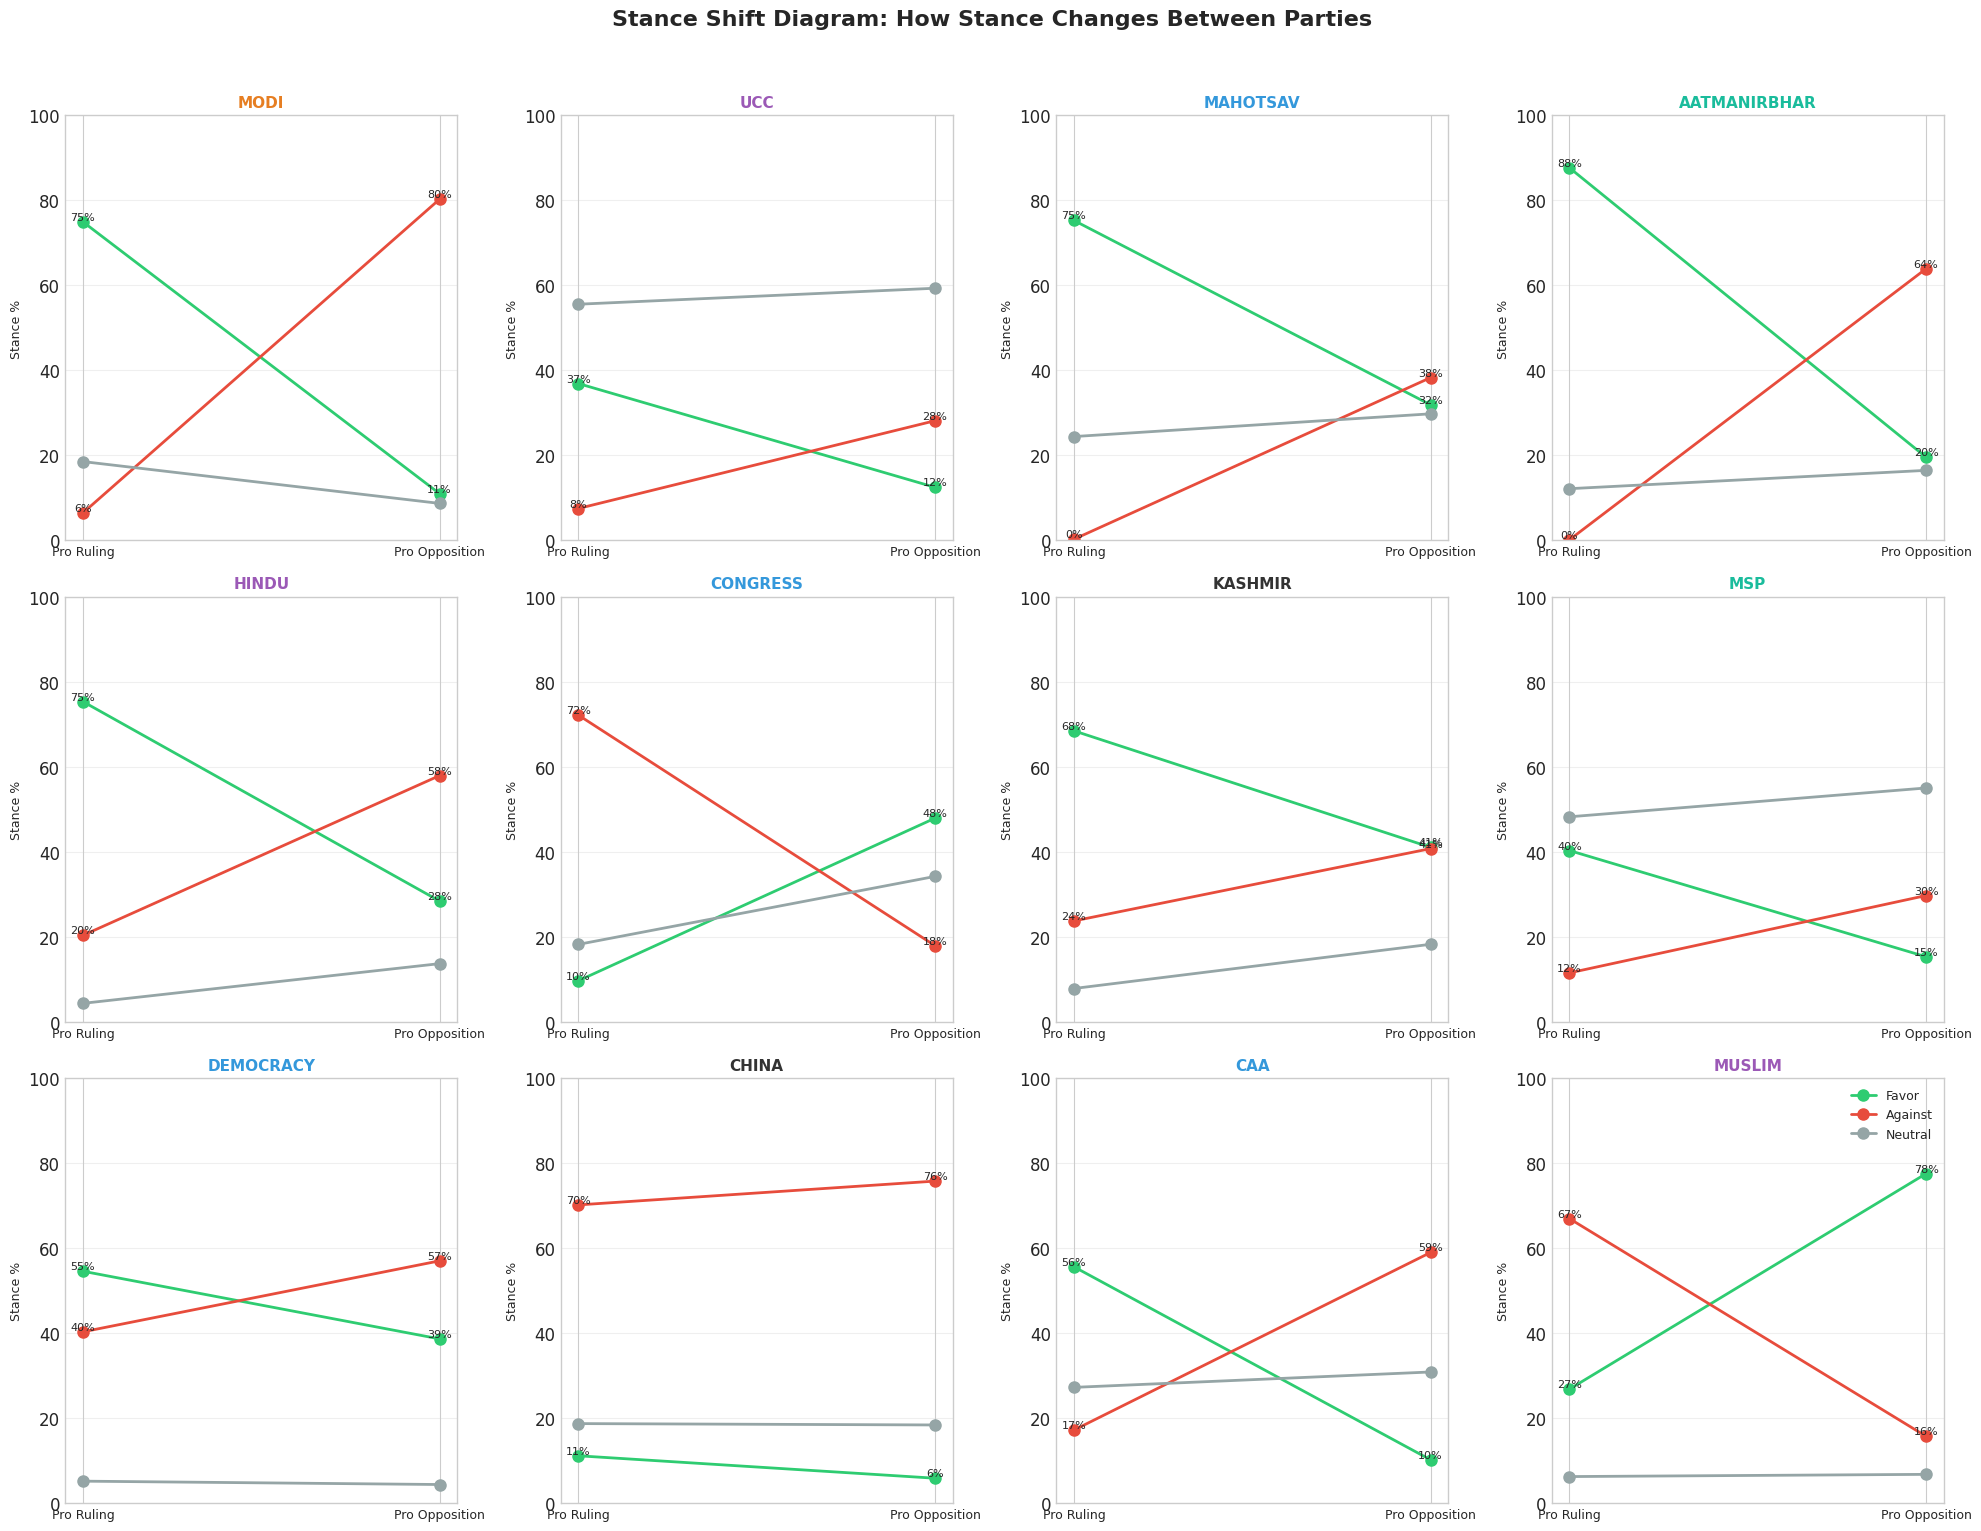

Saved: stance_shift_diagram.png


In [7]:
# ============================================================================
# STANCE SHIFT DIAGRAM: HOW STANCE CHANGES BETWEEN PARTIES
# Slope chart showing favor/against/neutral for each party
# ============================================================================

top_kws = polarization_df.nlargest(12, 'ruling_count')['keyword'].tolist()

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, keyword in enumerate(top_kws):
    row = polarization_df[polarization_df['keyword'] == keyword].iloc[0]
    
    parties = ['Pro Ruling', 'Pro Opposition']
    favor_vals = [row['ruling_favor'], row['opp_favor']]
    against_vals = [row['ruling_against'], row['opp_against']]
    neutral_vals = [row['ruling_neutral'], row['opp_neutral']]
    
    x = [0, 1]
    
    # Plot slope lines
    axes[idx].plot(x, favor_vals, 'o-', color=STANCE_COLORS['favor'], 
                   linewidth=2, markersize=8, label='Favor')
    axes[idx].plot(x, against_vals, 'o-', color=STANCE_COLORS['against'], 
                   linewidth=2, markersize=8, label='Against')
    axes[idx].plot(x, neutral_vals, 'o-', color=STANCE_COLORS['neutral'], 
                   linewidth=2, markersize=8, label='Neutral')
    
    # Value labels
    for i, party in enumerate(parties):
        axes[idx].annotate(f'{favor_vals[i]:.0f}%', (x[i], favor_vals[i]), 
                          fontsize=8, ha='center', va='bottom')
        axes[idx].annotate(f'{against_vals[i]:.0f}%', (x[i], against_vals[i]), 
                          fontsize=8, ha='center', va='bottom')
    
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(parties, fontsize=9)
    axes[idx].set_ylabel('Stance %', fontsize=9)
    axes[idx].set_ylim(0, 100)
    
    title_color = BUCKET_COLORS.get(row['bucket'], '#333')
    axes[idx].set_title(keyword.upper(), fontweight='bold', fontsize=11, color=title_color)
    axes[idx].grid(axis='y', alpha=0.3)

axes[-1].legend(loc='upper right', fontsize=9)

plt.suptitle('Stance Shift Diagram: How Stance Changes Between Parties', 
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('stance_shift_diagram.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: stance_shift_diagram.png")

## 7. Joint Distribution Heatmap

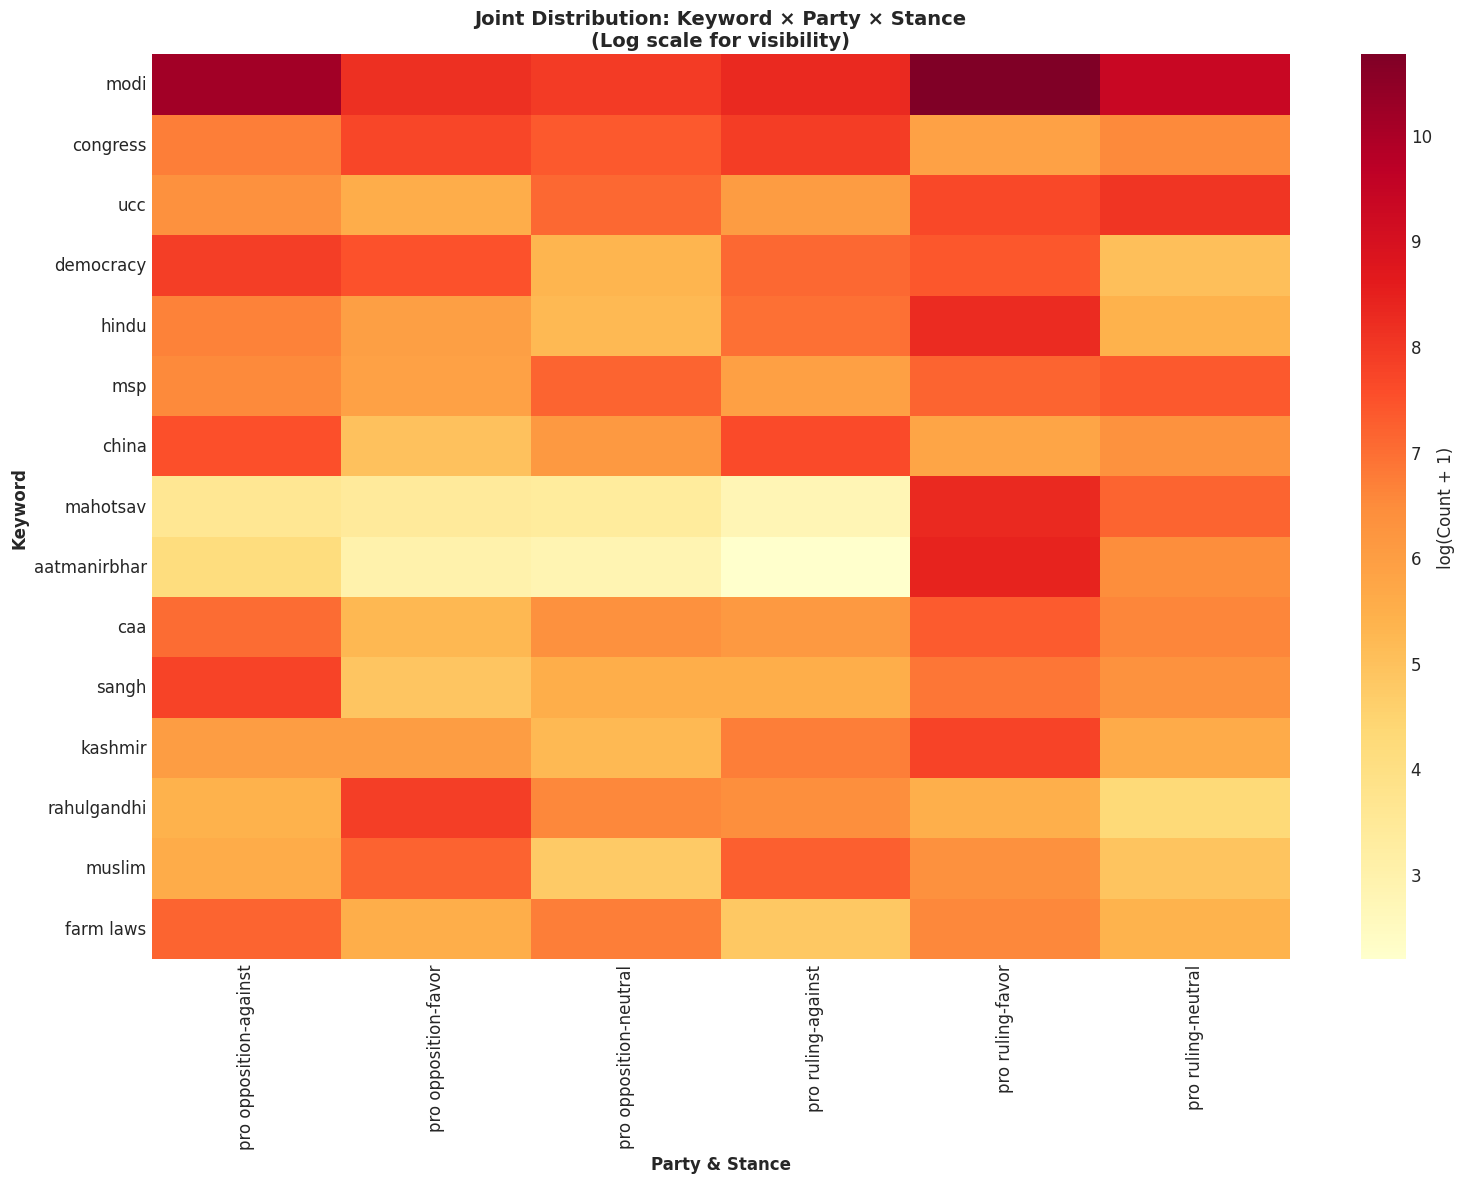

Saved: joint_distribution_heatmap.png


In [8]:
# ============================================================================
# JOINT DISTRIBUTION: KEYWORD x PARTY x STANCE
# Shows count matrix for all combinations
# ============================================================================

joint_data = df.groupby(['keyword', 'party', 'stance']).size().reset_index(name='count')
joint_pivot = joint_data.pivot_table(index='keyword', columns=['party', 'stance'], 
                                      values='count', fill_value=0)

# Top 15 keywords by volume
top_keywords = df['keyword'].value_counts().head(15).index.tolist()
joint_pivot_filtered = joint_pivot.loc[top_keywords].astype(float)

# Log scale for visibility
joint_pivot_log = np.log1p(joint_pivot_filtered)

fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(joint_pivot_log, annot=False, cmap='YlOrRd', ax=ax,
            cbar_kws={'label': 'log(Count + 1)'})

ax.set_title('Joint Distribution: Keyword × Party × Stance\n(Log scale for visibility)', 
            fontweight='bold', fontsize=14)
ax.set_ylabel('Keyword', fontweight='bold')
ax.set_xlabel('Party & Stance', fontweight='bold')

plt.tight_layout()
plt.savefig('joint_distribution_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: joint_distribution_heatmap.png")

## 8. Radar Chart: Party Focus Across Buckets

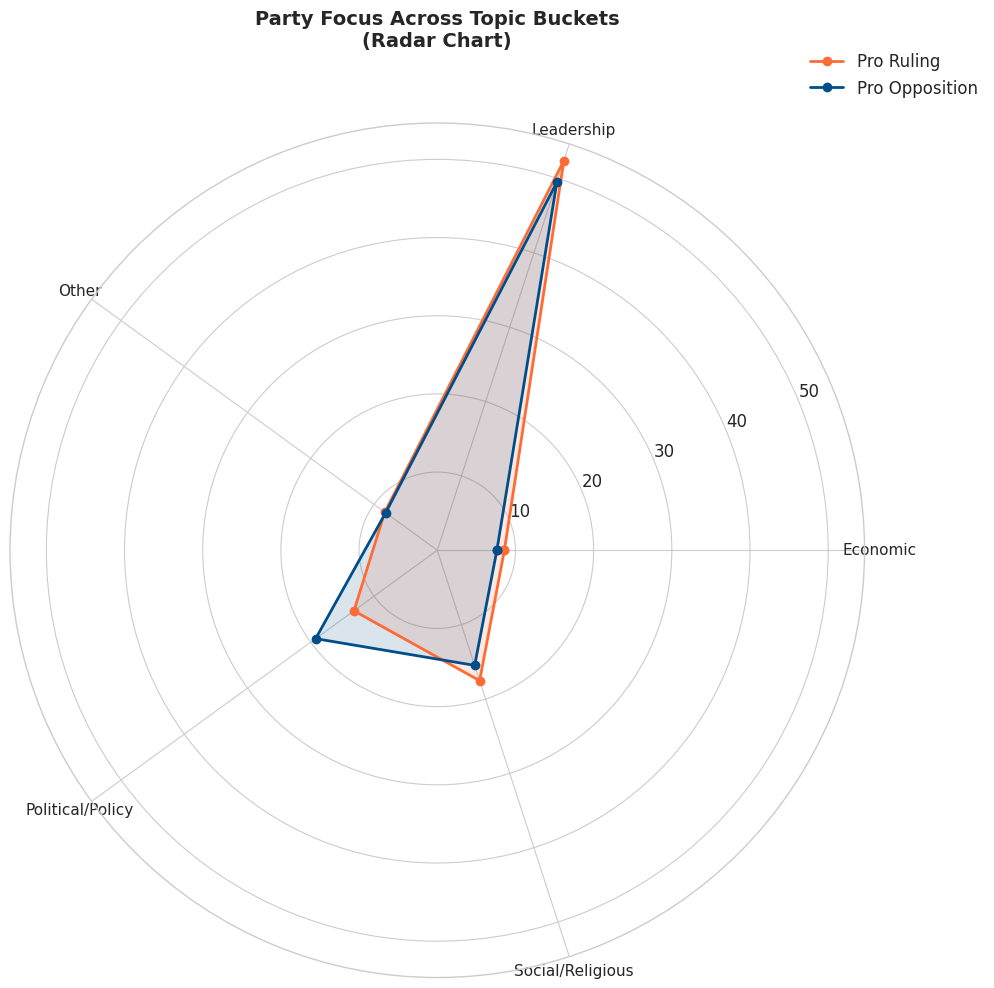

Saved: party_focus_radar.png


In [9]:
# ============================================================================
# RADAR CHART: PARTY FOCUS ACROSS TOPIC BUCKETS
# ============================================================================

bucket_counts = df.groupby(['party', 'bucket']).size().unstack(fill_value=0)
bucket_pct = bucket_counts.div(bucket_counts.sum(axis=1), axis=0) * 100

categories = bucket_pct.columns.tolist()
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the plot

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for party, color in PARTY_COLORS.items():
    if party in bucket_pct.index:
        values = bucket_pct.loc[party].values.tolist()
        values += values[:1]  # Close the plot
        ax.plot(angles, values, 'o-', linewidth=2, label=party.title(), color=color)
        ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_title('Party Focus Across Topic Buckets\n(Radar Chart)', 
            fontweight='bold', fontsize=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.1))

plt.tight_layout()
plt.savefig('party_focus_radar.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: party_focus_radar.png")

## 9. Summary

In [10]:
# ============================================================================
# LIST ALL GENERATED VISUALIZATIONS
# ============================================================================

import os

print("\n" + "=" * 80)
print("GENERATED VISUALIZATIONS")
print("=" * 80)

viz_files = sorted([f for f in os.listdir('.') if f.endswith('.png')])
for i, f in enumerate(viz_files, 1):
    size = os.path.getsize(f) / 1024
    print(f"  {i}. {f} ({size:.1f} KB)")

print(f"\n📊 Total: {len(viz_files)} visualizations")
print("=" * 80)


GENERATED VISUALIZATIONS
  1. advanced_overall_stance.png (101.7 KB)
  2. bucket_stance_analysis.png (136.0 KB)
  3. joint_distribution_heatmap.png (120.2 KB)
  4. keyword_breakdown_comparison.png (211.2 KB)
  5. keyword_volume_scatter.png (154.9 KB)
  6. party_focus_radar.png (236.2 KB)
  7. party_topic_focus.png (92.3 KB)
  8. polarization_analysis.png (169.1 KB)
  9. stance_correlation_matrix.png (143.8 KB)
  10. stance_heatmap_by_keyword.png (523.2 KB)
  11. stance_overlap_analysis.png (137.6 KB)
  12. stance_scatterplot_divergence.png (172.1 KB)
  13. stance_shift_diagram.png (424.6 KB)

📊 Total: 13 visualizations


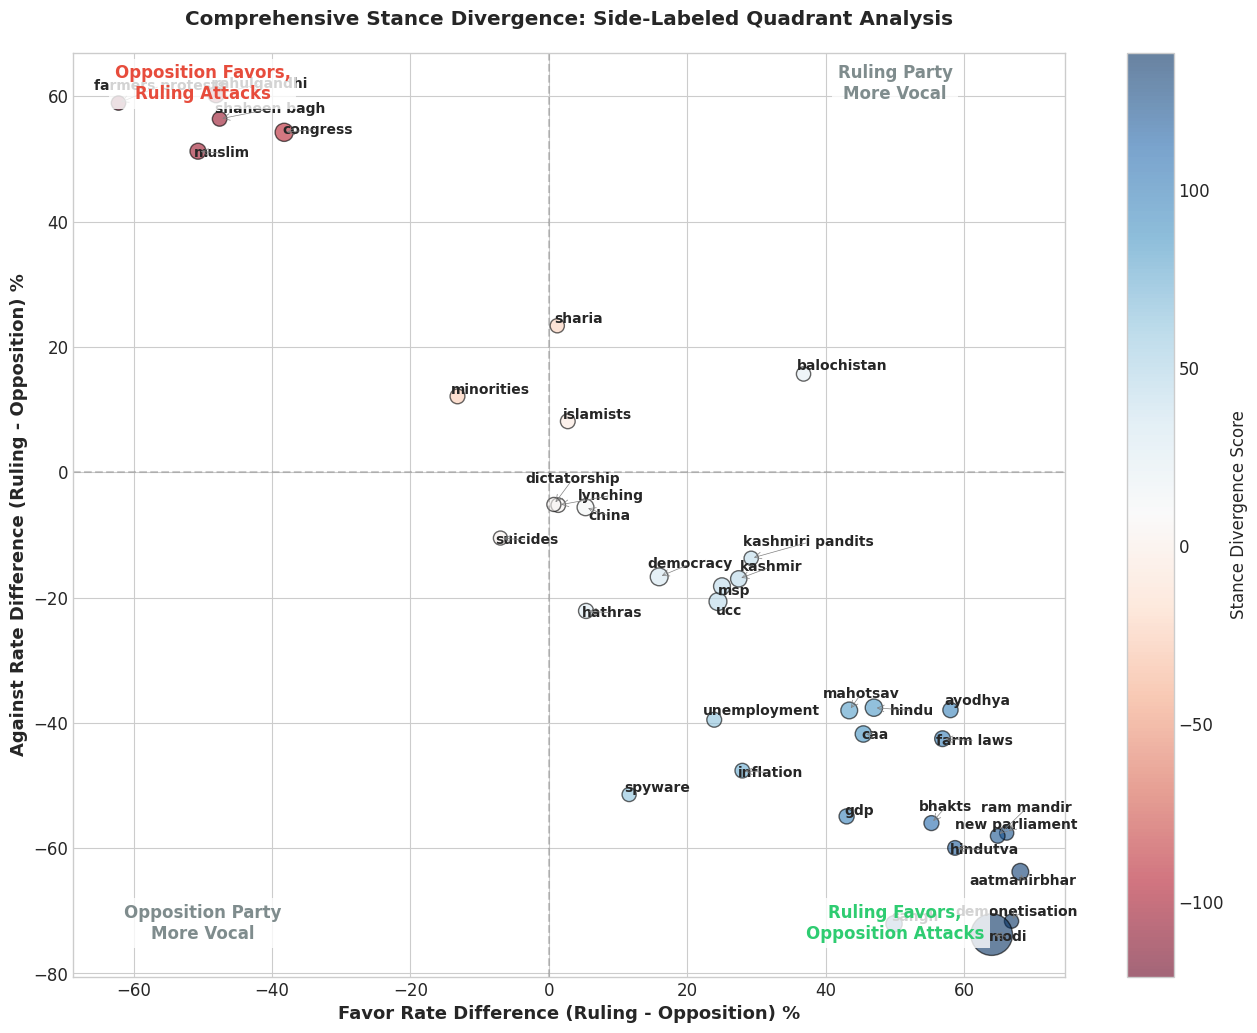

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Failsafe import for adjust_text
try:
    from adjust_text import adjust_text
except ImportError:
    try:
        from adjustText import adjust_text
    except ImportError:
        print("Warning: adjust_text not found. Labels will overlap.")
        def adjust_text(*args, **kwargs): return None

# ... [Keep your existing data loading and calculations] ...

fig, ax = plt.subplots(figsize=(16, 12))

# Calculations 
scatter_data = polarization_df.copy()
scatter_data['total'] = scatter_data['ruling_count'] + scatter_data['opp_count']
scatter_data['favor_diff'] = scatter_data['ruling_favor'] - scatter_data['opp_favor']
scatter_data['against_diff'] = scatter_data['ruling_against'] - scatter_data['opp_against']
sizes = (scatter_data['total'] / scatter_data['total'].max()) * 800 + 100
colors = scatter_data['stance_divergence']

# Plotting bubbles
scatter = ax.scatter(scatter_data['favor_diff'], scatter_data['against_diff'], 
                     s=sizes, c=colors, cmap='RdBu', alpha=0.6, 
                     edgecolors='black', linewidth=1)

# Labeling ALL points
texts = []
for idx, row in scatter_data.iterrows():
    texts.append(ax.text(row['favor_diff'], row['against_diff'], row['keyword'], 
                         fontsize=10, fontweight='bold'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5), expand_points=(1.5, 1.5))

# Reference lines at zero
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.4)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.4)

# --- QUADRANT LABELS (Moved to the sides/edges) ---
# We anchor these near the axis limits so they don't block the data
label_style = dict(fontsize=12, fontweight='bold', ha='center', va='center',
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=4))

# Top-Left side
ax.text(-50, 62, 'Opposition Favors,\nRuling Attacks', color='#e74c3c', **label_style)
# Top-Right side
ax.text(50, 62, 'Ruling Party\nMore Vocal', color='#7f8c8d', **label_style)
# Bottom-Right side
ax.text(50, -72, 'Ruling Favors,\nOpposition Attacks', color='#2ecc71', **label_style)
# Bottom-Left side
ax.text(-50, -72, 'Opposition Party\nMore Vocal', color='#7f8c8d', **label_style)
# --------------------------------------------------

ax.set_xlabel('Favor Rate Difference (Ruling - Opposition) %', fontweight='bold', fontsize=13)
ax.set_ylabel('Against Rate Difference (Ruling - Opposition) %', fontweight='bold', fontsize=13)
plt.colorbar(scatter, label='Stance Divergence Score')

plt.title('Comprehensive Stance Divergence: Side-Labeled Quadrant Analysis', fontweight='bold', pad=20)
plt.show()

In [2]:
!pip install adjustText